In [1894]:
import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt
import os
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/no_hsa_wood_1300g/2024-06-12_1718162368'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_1300g/godtest'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_1500g/godtest'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_1700g/godtest'
experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/no_hsa_wood_2300g/2024-06-12_1718162787'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_2300g/godtest'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_1900g/godtest'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_2100g/godtest'
with open(os.path.join(experiment_folder, 'experiment_config.yaml'), 'r') as f:
    experiment_config = yaml.load(f,yaml.Loader)
with open(os.path.join(experiment_folder, 'hardware_config.yaml'), 'r') as f:
    hardware_config = yaml.load(f,yaml.Loader)

# read tabular data
hop_files_relpath = [relpath for relpath in os.listdir(experiment_folder) if 'hop' in relpath]
hops = len(hop_files_relpath)*[None]
for relpath in hop_files_relpath:
    # hops.append(pd.read_csv(os.path.join(experiment_folder, relpath)))
    parts = os.path.splitext(relpath)
    hop_idx = int((parts[0].split('_'))[-1])
    hops[hop_idx] = pd.read_csv(os.path.join(experiment_folder, relpath))

energy = pd.read_csv(os.path.join(experiment_folder, 'energy.csv'))
ati_measurements = pd.read_csv(os.path.join(experiment_folder, 'ati_measurements.csv'))

[-0.6053963  -0.62526102 -0.67806509 -0.64914744 -0.66790964 -0.69232139
 -0.69842429 -0.73500472 -0.78379441 -0.64640566 -0.76481673 -0.76429818
 -0.47718866 -0.66891859 -0.7567812  -0.7052386  -0.78341942 -0.75567992
 -0.75376106 -0.71582788 -0.78489362 -0.71441265 -0.70687711 -0.76528611
 -0.69678994 -0.76288024 -0.76652775 -0.73220535 -0.73754664 -0.72267564
 -0.74967643 -0.76779458 -0.71767072 -0.73896532 -0.74865942 -0.71146793
 -0.73852386 -0.76074191 -0.76975356 -0.75182331 -0.73252147 -0.74205217
 -0.7112887  -0.76815624 -0.77151847 -0.73308446 -0.7444413  -0.72053389
 -0.74570213 -0.73812911]
[0.96012976 0.98806895 0.97946003 1.06189132 0.98156446 0.97240754
 1.00936821 1.01181893 0.9525954  0.98696633 0.94635856 0.99182671
 0.94688333 0.9837102  0.98363261 0.98960531 0.96847239 0.97168245
 0.96910464 0.99144777 0.95446377 0.95193615 0.9781111  0.97857612
 0.98543199 0.99704536 0.93465686 0.94878573 0.95474098 0.99417206
 1.00628922 0.95820647 0.96059348 0.99571686 0.92741948

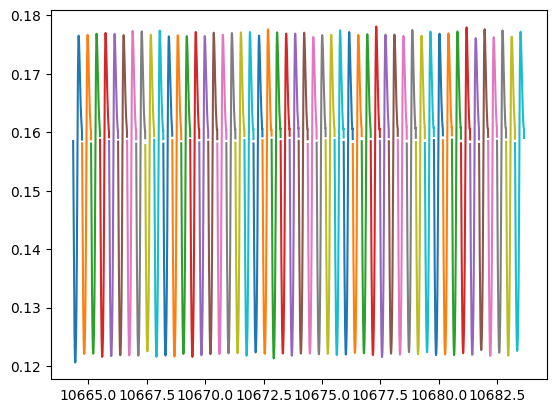

In [1895]:
initial_velocity = np.zeros(len(hops))
final_velocity = np.zeros(len(hops))
hop_height = np.zeros(len(hops))
hop_period = np.zeros(len(hops))
for i,hop in enumerate(hops):
    t = hop['t_s'].to_numpy()
    y = hop['y'].to_numpy()
    mode = hop['mode'].to_numpy()
    plt.plot(t,y)
    initial_velocity[i] = (y[1]-y[0])/(t[1]-t[0])
    j = next(j for j, m in enumerate(mode) if m==1)
    final_velocity[i] = .5*(y[j+1]-y[j])/(t[j+1]-t[j]) + .5*(y[j]-y[j-1])/(t[j]-t[j-1])
    hop_height[i] = final_velocity[i]**2 / (2*9.81)
    hop_period[i] = t[-1]-t[0]
print(initial_velocity)
print(final_velocity)
print(hop_height)
print(1/np.average(hop_period))

In [1896]:
hop_avg = np.average(hop_height)
hop_std = np.std(hop_height)
print(hop_std)

# filter outliers
outliers = [i for i,h in enumerate(hop_height) if h < .04 or h > .06 or np.any(np.diff(hops[i]['t_s']) > .01)]
# outliers = []
print(outliers)
hops = [h for i,h in enumerate(hops) if i not in outliers]
hop_height = np.array([h for i, h in enumerate(hop_height) if i not in outliers])
hop_energy = np.array([E for i,E in enumerate(energy.hop_energy.to_numpy()) if i not in outliers])

0.002729257648291642
[]


In [1897]:
# Calculate the height-normalized energy consumption
normalized_energy = np.average(hop_energy)/np.average(hop_height)
# normalized_energy = np.average(hop_energy/hop_height)
print('Energy Consumption:')
print(f'{normalized_energy:.3f} Joules \\ meter')

Energy Consumption:
59.020 Joules \ meter


0.04803207655526881
0.002729257648291642


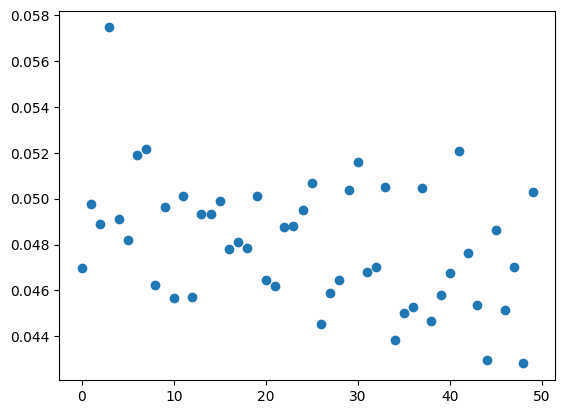

In [1898]:
"""
Now that we have indices to liftoff and touchdown, 
we can reorganize the data according to contact mode,
rather than the controller mode (which is how the data was originally saved)
"""
plt.scatter(list(range(len(hop_height))),hop_height)
print(np.average(hop_height))
print(np.std(hop_height))
# plt.scatter(list(range(len(hop_height))),energy.hop_energy/hop_height/100)
# plt.scatter(list(range(len(final_velocity))), final_velocity)

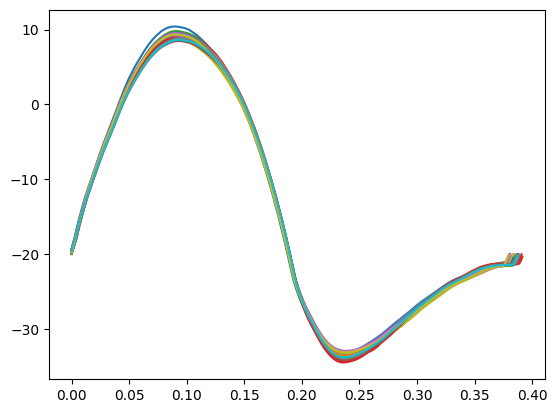

In [1899]:
for idx, hop in enumerate(hops):
    plt.plot(hop['t_s']-hop['t_s'][0],hop['x_deg'])

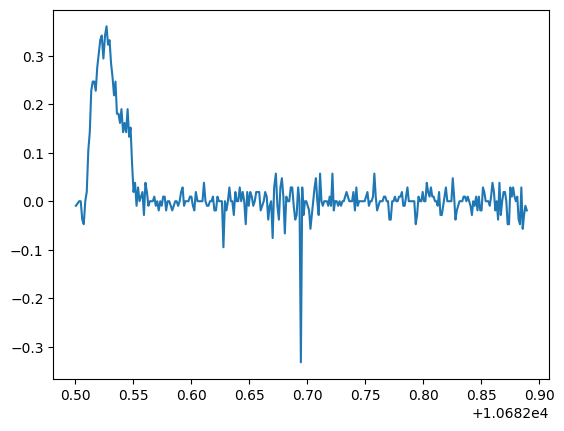

In [1900]:
plt.plot(hops[-3]['t_s'],.095*hops[-3]['d_current'])

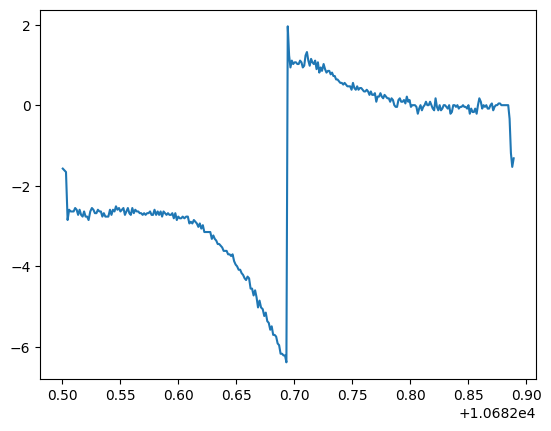

In [1901]:
plt.plot(hops[-3]['t_s'],hops[-3]['q_current']*.546*.78)

In [1902]:
R = .095
Kv = 105*(2*np.pi/60)/6
Kt = 1/Kv
Kfudge = 0.78

# compute the stance electrical power
power = np.zeros(len(hops))
pos_power = np.zeros(len(hops))
neg_power = np.zeros(len(hops))
# foo-power
for i, hop in enumerate(hops):
    x = hop['x_deg']*np.pi/180
    t = hop['t_s'] 
    xdot = np.diff(x)/np.diff(t)
    x = x[:-1]
    t = t[:-1]
    tau = hop['torque'][:-1]
    power[i] = np.trapz(R*(tau/(Kt*Kfudge))**2 + tau*xdot, x=t)
    pos_power[i] = np.trapz(np.clip(R*(tau/(Kt*Kfudge))**2 + tau*xdot, 0, np.inf), x=t)
    neg_power[i] = np.trapz(np.clip(R*(tau/(Kt*Kfudge))**2 + tau*xdot, -np.inf, 0), x=t)
    

In [1903]:
print(pos_power)
print(power)
print(hop_energy)

[3.44724058 3.49880518 3.49757977 3.5506077  3.51687918 3.53018262
 3.59132036 3.5459865  3.45956543 3.59429473 3.43933241 3.52250184
 3.48965361 3.57528758 3.48232441 3.5642199  3.52525146 3.54545136
 3.55783482 3.57525017 3.4403442  3.66962733 3.51105349 3.541537
 3.51863482 3.55988988 3.42712291 3.49672171 3.5228194  3.58126467
 3.5370445  3.46116713 3.50421715 3.66192502 3.42218661 3.5185987
 3.48511915 3.59190944 3.46460206 3.56146836 3.50557001 3.51934766
 3.50923728 3.59410583 3.39078489 3.58922353 3.37535287 3.54659067
 3.38872242 3.54473835]
[2.19603887 2.34863605 2.35093153 2.3706878  2.33557402 2.37616243
 2.41466318 2.38029123 2.32883696 2.40610809 2.29008055 2.37155875
 2.33390825 2.38828415 2.32715397 2.40893134 2.36982476 2.40075884
 2.41883361 2.39399913 2.30237735 2.52478594 2.29623261 2.40102986
 2.34859825 2.40924695 2.27846362 2.35253759 2.37780337 2.40197567
 2.36967897 2.31973739 2.36531482 2.49941333 2.23070722 2.38091199
 2.32082416 2.4494846  2.2999359  2.42739

[3.51900993 0.04803208]
[0.06335446 0.00275697]
0.5630201324279557


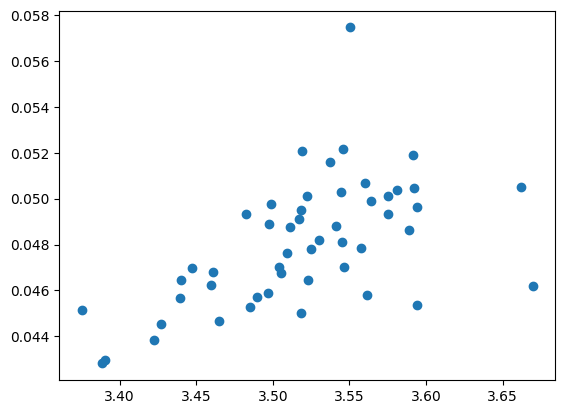

In [1904]:
X = pos_power
Y = hop_height
A = np.vstack((X,Y))
mean = A.mean(axis=1)
std = np.sqrt(1/(len(X)-1)*np.sum((A.T-mean)**2, axis=0))
corr = np.sum((X-mean[0])*(Y-mean[1]))/((len(X)-1)*std[0]*std[1])
print(mean)
print(std)
print(corr)
plt.scatter(X,Y)

73.45221894993378


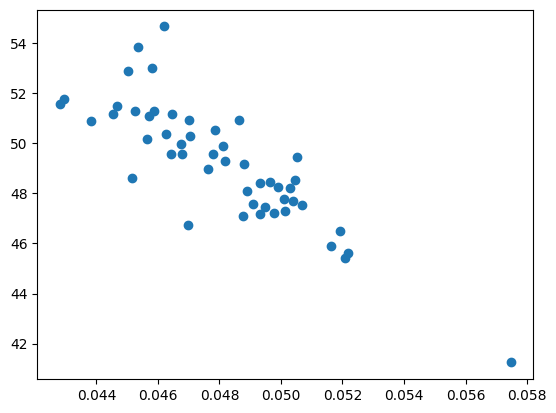

In [1905]:
plt.scatter(hop_height, power/hop_height)
print(np.average(pos_power/hop_height))